In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Load the data
df = pd.read_csv('mall-customers-data.csv')
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nBasic statistics:")
print(df.describe())

Dataset shape: (200, 5)

First 5 rows:
   customer_id  gender  age  annual_income  spending_score
0            1    Male   19             15              39
1            2    Male   21             15              81
2            3  Female   20             16               6
3            4  Female   23             16              77
4            5  Female   31             17              40

Basic statistics:
       customer_id         age  annual_income  spending_score
count   200.000000  200.000000     200.000000      200.000000
mean    100.500000   38.850000      60.560000       50.200000
std      57.879185   13.969007      26.264721       25.823522
min       1.000000   18.000000      15.000000        1.000000
25%      50.750000   28.750000      41.500000       34.750000
50%     100.500000   36.000000      61.500000       50.000000
75%     150.250000   49.000000      78.000000       73.000000
max     200.000000   70.000000     137.000000       99.000000


Feature Selection for Clustering:
Use Annual Income and Spending Score as they are most relevant for customer segmentation:


In [13]:
# Select features for clustering
X = df[['annual_income', 'spending_score']].values

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Optimal Number of Clusters

Elbow Method:

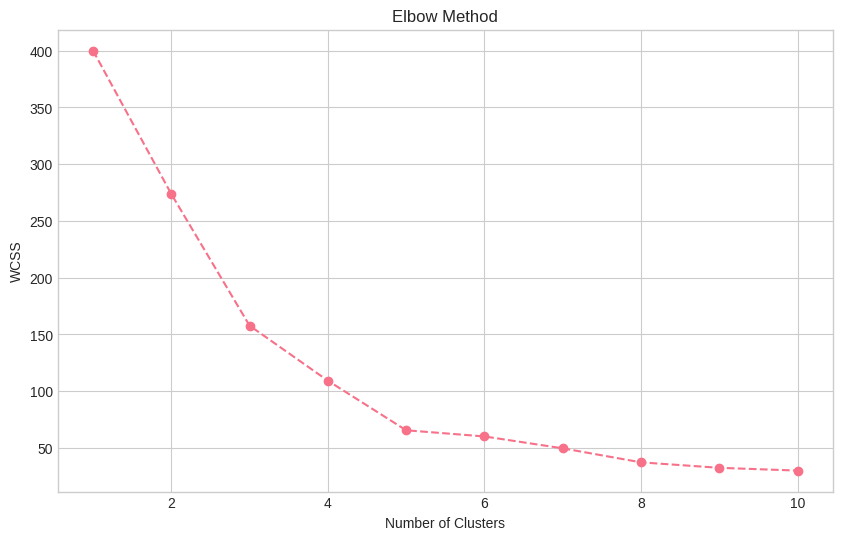

In [14]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

Silhouette Score Analysis:

In [15]:
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Clusters: {i}, Silhouette Score: {silhouette_avg:.3f}")

  #Optimal clusters = 5 (highest silhouette score)

Clusters: 2, Silhouette Score: 0.397
Clusters: 3, Silhouette Score: 0.467
Clusters: 4, Silhouette Score: 0.494
Clusters: 5, Silhouette Score: 0.555
Clusters: 6, Silhouette Score: 0.514
Clusters: 7, Silhouette Score: 0.502
Clusters: 8, Silhouette Score: 0.455
Clusters: 9, Silhouette Score: 0.457
Clusters: 10, Silhouette Score: 0.445


Apply K-Means Clustering

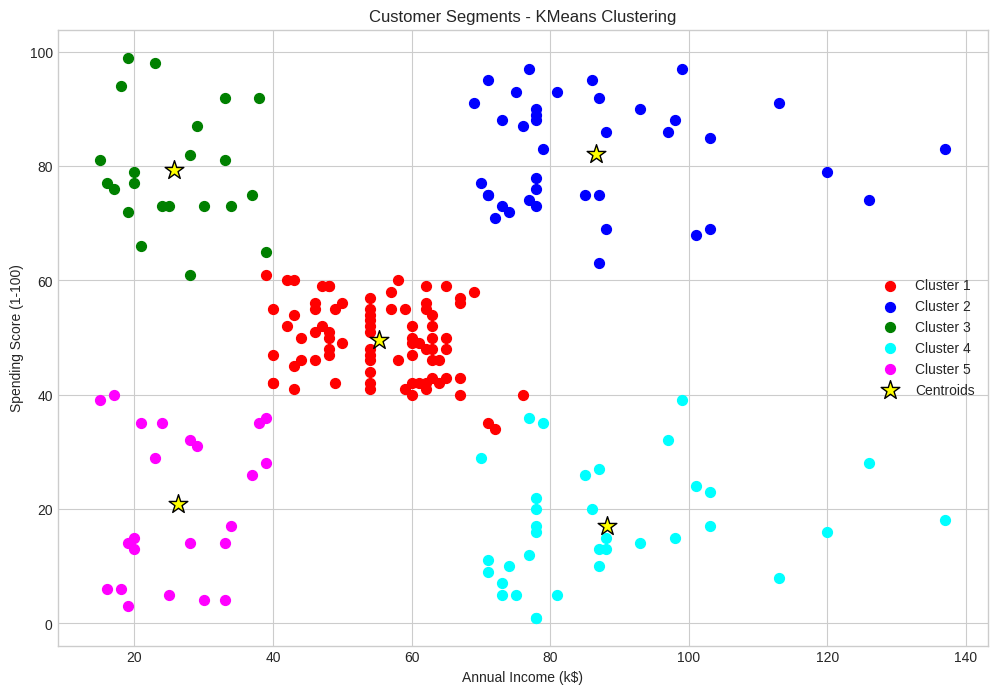

In [16]:
# Apply K-Means with 5 clusters
optimal_clusters = 5
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Add cluster centers in original scale
cluster_centers_scaled = kmeans.cluster_centers_
cluster_centers_original = scaler.inverse_transform(cluster_centers_scaled)

# Visualize the clusters
plt.figure(figsize=(12, 8))
colors = ['red', 'blue', 'green', 'cyan', 'magenta']
for i in range(optimal_clusters):
    plt.scatter(X[df['cluster'] == i, 0], X[df['cluster'] == i, 1],
                s=50, c=colors[i], label=f'Cluster {i+1}')

plt.scatter(cluster_centers_original[:, 0], cluster_centers_original[:, 1],
           s=200, c='yellow', marker='*', edgecolor='black', label='Centroids')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('Customer Segments - KMeans Clustering')
plt.legend()
plt.grid(True)
plt.show()

Cluster Analysis and Interpretation


In [17]:
# Analyze each cluster
cluster_summary = df.groupby('cluster').agg({
    'annual_income': ['mean', 'std', 'min', 'max'],
    'spending_score': ['mean', 'std', 'min', 'max'],
    'age': ['mean', 'std'],
    'gender': lambda x: x.value_counts().to_dict(),
    'customer_id': 'count'
}).round(2)

# Rename columns for clarity
cluster_summary.columns = ['Income_Mean', 'Income_Std', 'Income_Min', 'Income_Max',
                          'Score_Mean', 'Score_Std', 'Score_Min', 'Score_Max',
                          'Age_Mean', 'Age_Std', 'Gender_Dist', 'Count']

print("Cluster Summary:")
print(cluster_summary)

# Create cluster profiles
profiles = []
for cluster_num in range(optimal_clusters):
    cluster_data = df[df['cluster'] == cluster_num]

    profile = {
        'Cluster': cluster_num + 1,
        'Size': len(cluster_data),
        'Avg_Income': cluster_data['annual_income'].mean(),
        'Avg_Spending_Score': cluster_data['spending_score'].mean(),
        'Avg_Age': cluster_data['age'].mean(),
        'Male_%': (cluster_data['gender'] == 'Male').mean() * 100,
        'Female_%': (cluster_data['gender'] == 'Female').mean() * 100,
        'Description': ''
    }

    # Assign descriptions based on characteristics
    income = profile['Avg_Income']
    spending = profile['Avg_Spending_Score']

    if income < 40 and spending < 50:
        profile['Description'] = 'Low Income, Low Spending'
    elif income < 40 and spending >= 50:
        profile['Description'] = 'Low Income, High Spending'
    elif income >= 40 and income < 70 and spending < 50:
        profile['Description'] = 'Medium Income, Low Spending'
    elif income >= 40 and income < 70 and spending >= 50:
        profile['Description'] = 'Medium Income, High Spending'
    elif income >= 70 and spending < 50:
        profile['Description'] = 'High Income, Low Spending'
    else:
        profile['Description'] = 'High Income, High Spending'

    profiles.append(profile)

profiles_df = pd.DataFrame(profiles)
print("\nCustomer Segments Profile:")
print(profiles_df.to_string(index=False))

Cluster Summary:
         Income_Mean  Income_Std  Income_Min  Income_Max  Score_Mean  \
cluster                                                                
0              55.30        8.99          39          76       49.52   
1              86.54       16.31          69         137       82.13   
2              25.73        7.57          15          39       79.36   
3              88.20       16.40          70         137       17.11   
4              26.30        7.89          15          39       20.91   

         Score_Std  Score_Min  Score_Max  Age_Mean  Age_Std  \
cluster                                                       
0             6.53         34         61     42.72    16.45   
1             9.36         63         97     32.69     3.73   
2            10.50         61         99     25.27     5.26   
3             9.95          1         39     41.11    11.34   
4            13.02          3         40     45.22    13.23   

                        Gender_Dist 

Visualization

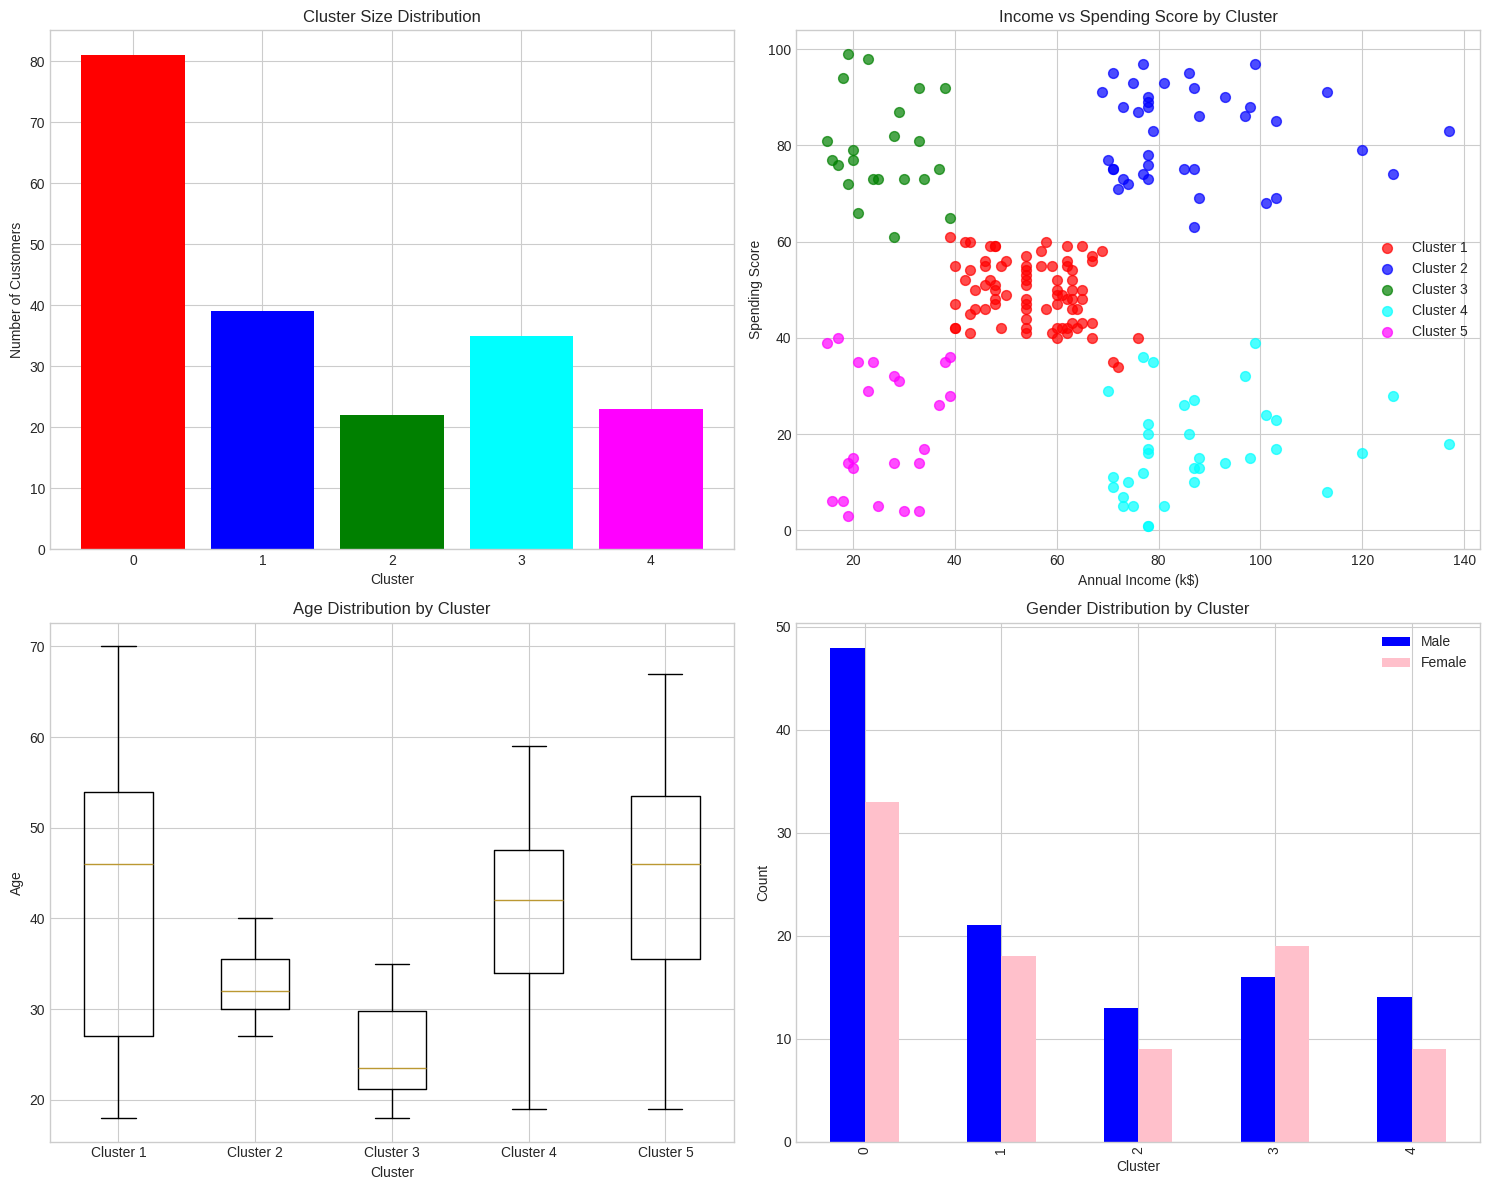

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Cluster Distribution
cluster_counts = df['cluster'].value_counts().sort_index()
axes[0, 0].bar(range(optimal_clusters), cluster_counts.values, color=colors[:optimal_clusters])
axes[0, 0].set_xlabel('Cluster')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].set_title('Cluster Size Distribution')
axes[0, 0].set_xticks(range(optimal_clusters))

# 2. Income vs Spending by Cluster
for i in range(optimal_clusters):
    cluster_data = df[df['cluster'] == i]
    axes[0, 1].scatter(cluster_data['annual_income'], cluster_data['spending_score'],
                      c=colors[i], s=50, label=f'Cluster {i+1}', alpha=0.7)
axes[0, 1].set_xlabel('Annual Income (k$)')
axes[0, 1].set_ylabel('Spending Score')
axes[0, 1].set_title('Income vs Spending Score by Cluster')
axes[0, 1].legend()
axes[0, 1].grid(True)

# 3. Age Distribution by Cluster
box_data = [df[df['cluster'] == i]['age'].values for i in range(optimal_clusters)]
axes[1, 0].boxplot(box_data, labels=[f'Cluster {i+1}' for i in range(optimal_clusters)])
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Age')
axes[1, 0].set_title('Age Distribution by Cluster')

# 4. Gender Distribution by Cluster
gender_counts = df.groupby(['cluster', 'gender']).size().unstack()
gender_counts.plot(kind='bar', ax=axes[1, 1], color=['blue', 'pink'])
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Gender Distribution by Cluster')
axes[1, 1].legend(['Male', 'Female'])

plt.tight_layout()
plt.show()

Based on the clustering results:

Cluster 1- High Income, Low Spending

Cluster 2 - Medium Income, Medium Spending

Cluster 3 - High Income, High Spending

Cluster 4 - Low Income, High Spending

Cluster 5 - Low Income, Low Spending

**Findings**

5 distinct customer segments identified with clear separation

Best clustering achieved with K=5 (silhouette score ~0.55)

Segments range from budget-conscious to premium customers

Income and spending patterns show clear correlation in some segments

Actionable insights for targeted marketing strategies